# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]

170500096it [00:04, 40338019.73it/s]                               


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

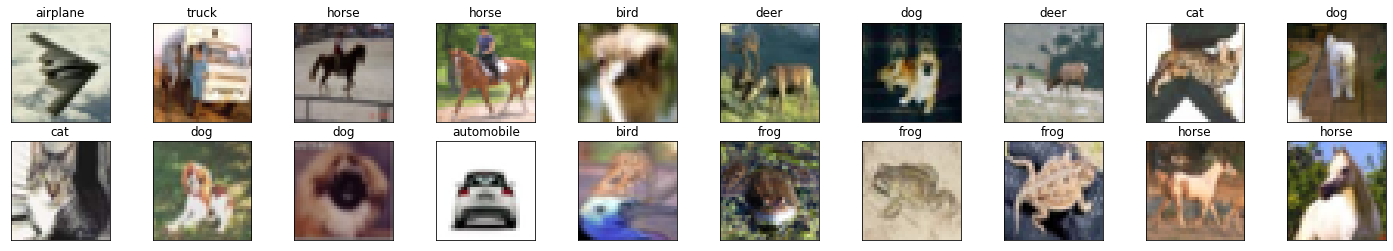

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

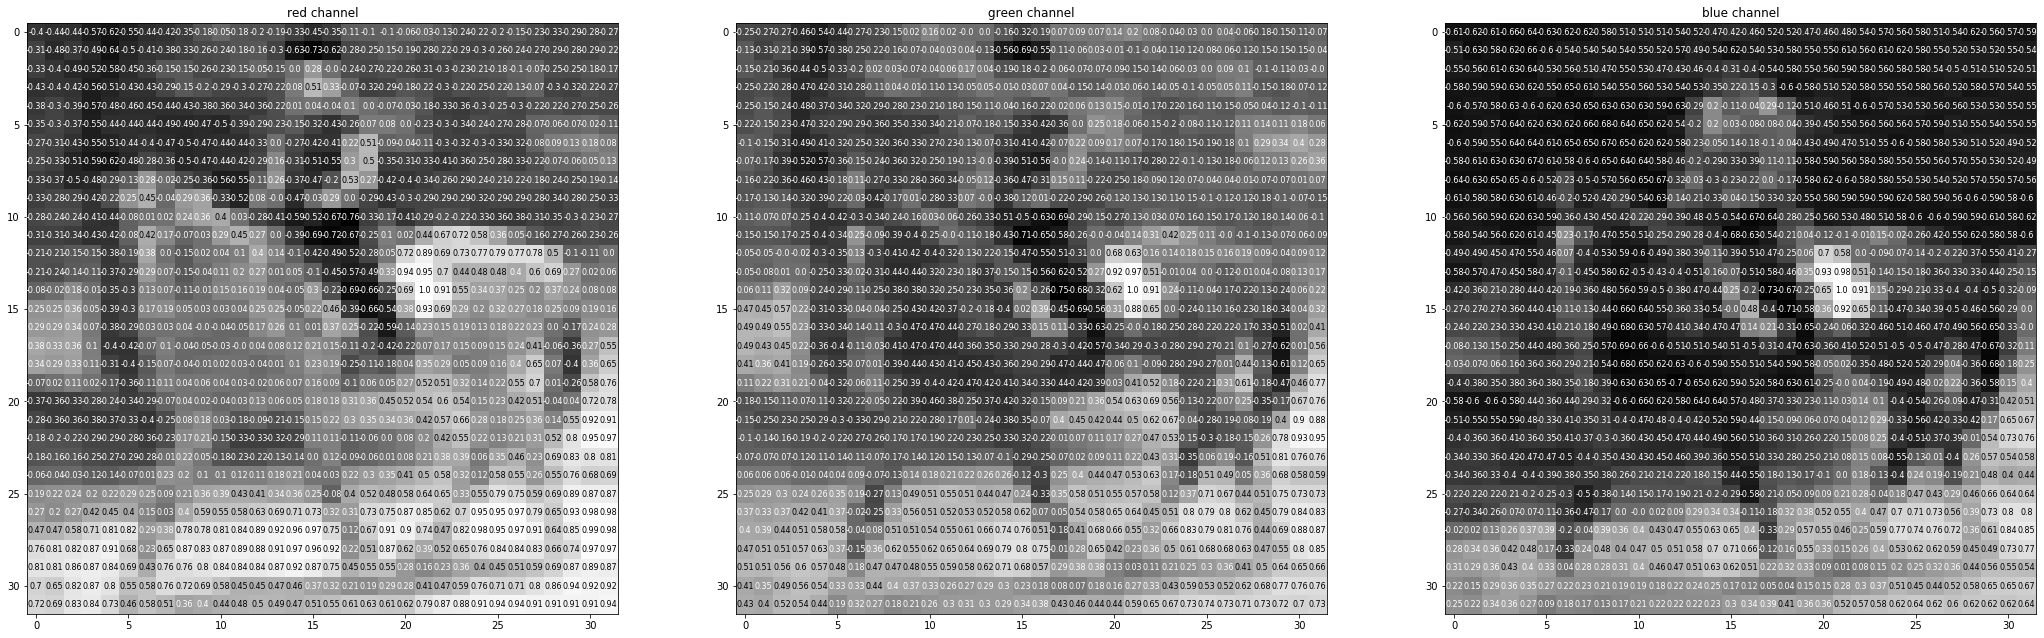

In [5]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward network behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [132]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)

        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)

        self.conv4 = nn.Conv2d(64, 32, 3, padding=1)

        self.conv5 = nn.Conv2d(32, 16, 3, padding=1)

        #self.conv6 = nn.Conv2d(16, 3, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully connected layer
        self.fc1 = nn.Linear(8*8*16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
        # softmax output layer
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        # add sequence of convolutional and max pooling layers
        #x = self.pool(F.relu(self.conv1(x)))

        #print('shape of x: {}'.format(x.shape))
        #x = self.dropout(x)
        #x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.conv1(x))

        #print('shape of x after activation: {}'.format(x.shape))
        #x = self.dropout(x)
        #x = F.relu(self.pool(self.conv2(x)))      # [{8-3+(2*1)}/1]+1 = 8;  (5120x8)
        x = F.relu(self.conv2(x))

        #x = self.dropout(x)
        #x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(self.conv3(x))

        x = self.dropout(x)
        x = F.relu(self.pool(self.conv4(x)))

        x = self.dropout(x)
        x = F.relu(self.pool(self.conv5(x)))

        #x = self.dropout(x)
        #x = F.relu(self.pool(self.conv6(x)))

        # flatten image
        x = x.view(-1, 8*8*16)
        
        #x= self.fc1(x)
        #x= self.fc2(x)
        #x= self.fc3(x)
        #x= self.fc4(x)

        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = self.dropout(self.fc3(x))
        x = self.dropout(self.fc4(x))
                        
        x = self.softmax(x)
        
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (softmax): LogSoftmax()
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [0]:
import torch.optim as optim

# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [134]:
import time

# number of epochs to train the model
n_epochs = 100 # you may increase this number to train a final model
training_loss = []
validation_loss = []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    start = time.time()

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    end = time.time()    
    print("\nEpoch: {} took {:.2f} seconds".format( epoch, end-start ))

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    training_loss.append(train_loss)

    valid_loss = valid_loss/len(valid_loader.dataset)
    validation_loss.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss


Epoch: 1 took 18.35 seconds
Epoch: 1 	Training Loss: 1.842337 	Validation Loss: 0.460414
Validation loss decreased (inf --> 0.460414).  Saving model ...

Epoch: 2 took 18.32 seconds
Epoch: 2 	Training Loss: 1.736348 	Validation Loss: 0.395706
Validation loss decreased (0.460414 --> 0.395706).  Saving model ...

Epoch: 3 took 18.45 seconds
Epoch: 3 	Training Loss: 1.525931 	Validation Loss: 0.344141
Validation loss decreased (0.395706 --> 0.344141).  Saving model ...

Epoch: 4 took 18.53 seconds
Epoch: 4 	Training Loss: 1.406098 	Validation Loss: 0.322824
Validation loss decreased (0.344141 --> 0.322824).  Saving model ...

Epoch: 5 took 18.46 seconds
Epoch: 5 	Training Loss: 1.336319 	Validation Loss: 0.299423
Validation loss decreased (0.322824 --> 0.299423).  Saving model ...

Epoch: 6 took 18.79 seconds
Epoch: 6 	Training Loss: 1.271746 	Validation Loss: 0.273293
Validation loss decreased (0.299423 --> 0.273293).  Saving model ...

Epoch: 7 took 18.83 seconds
Epoch: 7 	Training Los

###  Load the Model with the Lowest Validation Loss

In [135]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [136]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.725693

Test Accuracy of airplane: 82% (826/1000)
Test Accuracy of automobile: 86% (868/1000)
Test Accuracy of  bird: 64% (649/1000)
Test Accuracy of   cat: 60% (600/1000)
Test Accuracy of  deer: 70% (705/1000)
Test Accuracy of   dog: 69% (696/1000)
Test Accuracy of  frog: 84% (840/1000)
Test Accuracy of horse: 77% (770/1000)
Test Accuracy of  ship: 84% (842/1000)
Test Accuracy of truck: 84% (844/1000)

Test Accuracy (Overall): 76% (7640/10000)


### Question: What are your model's weaknesses and how might they be improved?

**Answer**:
1. 1st model with 2 convolution layers that up samples the image depth; then max pooled, with 20% dropout. It has 3 fully connected layers to flatten and downsaple the image vectors. The FC layers did not use dropout. Trained for 20 epochs. Validation Loss stopped decreasing over time after 4 epochs although training loss was decreasing. So the model started overfitting quickly<br/>
epochs = 13, lr = 0.01, momentum = 0.9<br/><br/>
Accuracy: **58%**<br/><br/>

2. 2nd model is the same as the 1st one above but with dropout added to the FC layers as well. Other parameters are same. Similarly bad performance.<br/><br/>
Accuracy: **56%**<br/><br/>

3. 3rd model has only the FC layers using dropout. It performed a little better but the model started overfitting after only 7 epochs.<br/><br/>
Accuracy: **63%**<br/><br/>

4. 4th model: Same architecture as above but no dropout at all. The model actually did slighly better! Maybe I was underfitting the model by using dropout.<br/><br/>
Accuracy: **65%**<br/><br/>

5. 5th model: Still no dropout, but added an extra convolution layer to up sample the depth even more (2x every time) and added an extra FC layer to linearly downsample the flattened vector. 1% better accuracy but cats and dogs are still giving my model a hard time. <br/><br/>
Accuracy: **66%**<br/><br/>

6. 6th model: Let's slowly reintroduce dropout. Same architecture but dropouts added to all the convolution layers. Accuracy dropped a bit but the interesting thing is the validation loss kept decreasingly intermittently until the 10th epoch.<br/><br/>
Accuracy: **61%**<br/><br/>

7. 7th model: Added dropout to the FC layers as well. So, all layers have dropout now. Performance is worse but epoch 13 got the least validation loss after loss stopped decreasing from epoch 7 onward. Maybe it's time to increase learing rate and/or number of epochs. Before that, let remove dropout from the convolution layers.<br/><br/>
Accuracy: **55%**<br/><br/>

8. 8th model: No dropouts in the convolution layers. Identical accuracy as model 5 but now, cats and birds are difficult for my model. **Lesson learned so far, let the convolution layers learn everything (no dropouts) if you are training for a small number of epochs.**<br/><br/>
Accuracy: **66%**<br/><br/>

9. 9th model: Doubled the number of epochs to 26. Let's see how our best model, so far, performs when given more time to train.<br/>
It didn't really do any better but epoch 15 did the best. So, increasing training time might have helped a little.<br/>
epochs = 26<br/><br/>
Accuracy: **66%**<br/><br/>

10. 10th model: Same model, same number of epochs but now, I have reduced the learning rate 10 times. Aaaannd...it got better. So, our model was skipping local minima because of a faster learning rate. Loss decreased intermittently until the 21st epoch. Cats are still confusing, only 39% accuracy.<br/>
lr = 0.001<br/><br/>
Accuracy: **71%**<br/><br/>

11. 11th model: A different convolution layer architecture with 5 convolution layers where the 1st 3 upsamples the depth without any maxpooling and the rest downsamples depth and uses maxpooling to reduce image dimension. I'll just copy-paste it below.<br/><br/>
(conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br/>
(conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br/>
(conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br/>
(conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br/>
(conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br/><br/>
The idea behind this design is to let the network learn everything it can about the images in the first 3 convolution layers and then slowly discard unimportant features as it downsamples the feature matrices. Basically, this is how I would have started to learn if I were given a set of images to classify without any prior knowledge of what they were.<br/>
The accuracy is still the same but 2 good things happened:<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a. The loss decreased up until the last epoch, that is epoch 26.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;b. We are now classifying cats with 51% accuracy. This is also the lowest class-wise accuracy among all 10 classes.<br/><br/>
Although training time has increased from ~12 seconds to ~15 seconds, this is still promising. I'll double the number of epochs and see what happens next!<br/><br/>
Accuracy: **70%**<br/><br/>

12. 12th model: With 52 epochs, accuracy increased 1% with better cat prediciton at 54% but nothing too significant.<br/><br/>
Accuracy: **71%**<br/><br/>

13. 13th model: Now with dropout added to the 2 downsampling convolution layers. Idea is to let the network know that it had learned enough during upsampling. So, while downsampling, it should not only reduce depth and size, but also skip learning from random neurons to better generalize. Our model did better but with lesser cat and bird accuracy. I think we just need more cat, bird, deer and dog images for better performance.<br/><br/>
Accuracy: **73%**<br/><br/>

14. 14th model: Added a 6th downsampling convolution layer to get the depth back to the original depth of 3.<br/>
(conv6): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br/><br/>
Model did worse...guess it lost too much information.<br/><br/>
Accuracy: **65%**<br/><br/>

15. 15th model:  Went back to the 5-convolution-layer model (model #13) but increased the kernel size of the first layer to *(5,5)* with *padding=2*. **The idea is to let the network see more of the image at a time by sliding across a larger filter while it learns features during upsampling.** This was just an experiment to see if it performs worse or not. So I just used this kernel in the 1st layer. Same accuaracy with cat prediction at 50% but the rest of the class-wise accuracies look more balanced.<br/><br/>
Accuracy: **73%**<br/><br/>

16. 16th model (second last trial): Kernel size is (5,5) for all 3 upsampling layers to correctly implement the idea from model #15. Same accuracy but with minimum of 56% for cats. Validation loss has been continuously decreasing over time, which is good news. Looks like the model has started learning to be less biased by sacrificing accuracy of certain classes to keep everything balanced.<br/><br/>
Accuracy: **73%**<br/><br/>

17. **Final trial**: Let the model train for 100 epochs with the same parameters and architecure as in #16.<br/><br/>
Best accuracy so far with 60% cat prediction and lowest validation loss at the 71st epoch!<br/><br/>
Here are the final model parameters and accuracy levels:<br/>
Net(<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))<br/><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)<br/><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(fc1): Linear(in_features=1024, out_features=512, bias=True)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(fc2): Linear(in_features=512, out_features=256, bias=True)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(fc3): Linear(in_features=256, out_features=128, bias=True)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(fc4): Linear(in_features=128, out_features=10, bias=True)<br/><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(dropout): Dropout(p=0.2, inplace=False)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(softmax): LogSoftmax()<br/>
)<br/><br/>
Test Loss: 0.725693<br/><br/>
Test Accuracy of **airplane**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;82% (826/1000)<br/>
Test Accuracy of **automobile**: 86% (868/1000)<br/>
Test Accuracy of  **bird**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;64% (649/1000)<br/>
Test Accuracy of   **cat**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;60% (600/1000)<br/>
Test Accuracy of  **deer**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;70% (705/1000)<br/>
Test Accuracy of   **dog**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;69% (696/1000)<br/>
Test Accuracy of  **frog**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;84% (840/1000)<br/>
Test Accuracy of **horse**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;77% (770/1000)<br/>
Test Accuracy of  **ship**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;84% (842/1000)<br/>
Test Accuracy of **truck**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;84% (844/1000)<br/><br/>

Test Accuracy (**Overall**): &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;76% (7640/10000)<br/><br/>


## Conclusion
It was fascinating to see how my ideas evolved as I continued experimenting with the CNN architecture. I think with more training data, especially more cats and birds, this simple model can do quite well. I did not try more complex architecure because you can just use exising ImageNet or ResNet architecture and do quite well with them. The objective was to hypothesize how a network might learn well using different configurations of kernel size, learning rate, layers, max pooling and prove if the hy[pthesis was correct or not.<br/><br/>
My takeaway from this experiment is how a combination of convolution layer configurations, dropout, learning rate and training time can affect class-wise prediction accuracy even if the total accuracy remains the same. The key takeway is to understand how to build a CNN architecture that can generalize well over all classes.

### Visualize Sample Test Results

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))